In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.under_sampling import ClusterCentroids, EditedNearestNeighbours

import warnings
warnings.filterwarnings('ignore')

## Function for grid plotting

In [2]:
def grid_plot(df):
    df_melt = pd.melt(df, id_vars=[], value_vars=df.columns)
    sns.set_style("darkgrid")
    g = sns.FacetGrid(df_melt, col='variable', col_wrap=4, sharex=False, sharey=False)
    g.map(sns.histplot, 'value')

    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
    plt.tight_layout()

## Function for one hot encoding

In [3]:
def one_hot_encoding(df, cat_cols):
    df_cat = df[cat_cols]
    df_cat = df_cat.dropna()
    
    num_cols = [c for c in df.columns if c not in cat_cols]

    le = preprocessing.LabelEncoder()
    X_2 = df_cat.apply(le.fit_transform)
    enc = preprocessing.OneHotEncoder()
    enc.fit(X_2)
    onehotlabels = enc.transform(X_2)
    # transformed_df = pd.DataFrame(onehotlabels, columns=enc.get_feature_names_out())
    transformed_df = pd.DataFrame.sparse.from_spmatrix(onehotlabels, columns=enc.get_feature_names_out(), index=df_cat.index)
    return pd.concat([df[num_cols],transformed_df], axis = 1)


## Min Max Scaler

In [4]:
def min_max_scaler(df):
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(df)
    df_norm = scaler.transform(df)
    return pd.DataFrame(df_norm, columns=df.columns), scaler

## Function for training model - classifier

In [5]:
def train_test_classifier(X, Y, model = GradientBoostingClassifier(), random_state = None, test_size = 0.2):
    if test_size > 0:
        X_train, X_test, y_train, y_test = train_test_split(
            X, Y, test_size=test_size, random_state=random_state)
    else:
        X_train, X_test, y_train, y_test = X, X.iloc[0], Y, Y.iloc[0]

    #Definition and training of the model
    gbc=model
    # cc = ClusterCentroids(random_state=random_state)
    # X_resampled, y_resampled = cc.fit_resample(X_train, y_train)    

    # enn = EditedNearestNeighbours()
    # X_resampled, y_resampled = enn.fit_resample(X_train.to_numpy(), y_train.to_numpy())
    # X_resampled = pd.DataFrame(X_resampled, columns=X_train.columns)
    # y_resampled = pd.DataFrame(y_resampled)
    # y_resampled.name = 'Survived'

    X_resampled, y_resampled = X_train, y_train

    gbc.fit(X_resampled, y_resampled)

    if test_size > 0:
        score = gbc.score(X_test, y_test)
    else:    
        score = -1
    return gbc, score, X_train, X_test, y_train, y_test

## Data Transform

In [6]:
def general_transform(df):
    # Buckets cabin by starting letter

    df.loc[df['Sex'] == 'male','Age'] = pd.cut(x = df.loc[df['Sex'] == 'male','Age'] , bins = [-9999, -1, 5, 9999], labels=['adult_m', 'kid_m', 'adult_m'], ordered = False)  
    df.loc[df['Sex'] == 'female','Age'] = pd.cut(x = df.loc[df['Sex'] == 'female','Age'] , bins = [-9999, 9999], labels=['f'], ordered = False)
    
    if 'Cabin' in df.columns:
        df['Cabin'] = df.apply(lambda x: x['Cabin'][0], axis=1)

    # Truncates siblings, spouses, children, parents
    # df.loc[(df['SibSp'].astype('int32') < 2) & (df['Sex']=='male'),'SibSp'] = -1
    # df.loc[(df['SibSp'].astype('int32') >= 2) & (df['Sex']=='male'),'SibSp'] = 1
    # df.loc[(df['SibSp'].astype('int32') < 4) & (df['Sex']=='female'),'SibSp'] = -1
    # df.loc[(df['SibSp'].astype('int32') >= 4) & (df['Sex']=='female'),'SibSp'] = 1
   
    if 'SibSp' in df.columns:
        df['SibSp'] = df.apply(lambda x: 'HP' if ((x['SibSp'] < 2) and (x['Sex']=='male')) else 
                            ( 'LP' if x['Sex']=='male' else 
                                ( 'HP' if ((x['SibSp'] < 4) and (x['Sex']=='female')) else 'LP')                            
                            )
                            , axis=1                           
                            )

    if 'Parch' in df.columns:
        df['Parch'] = df.apply(lambda x: 'HP' if ((x['Parch'] < 2) and (x['Sex']=='male')) else 
                            ( 'LP' if x['Sex']=='male' else 
                                ( 'HP' if ((x['Parch'] < 4) and (x['Sex']=='female')) else 'LP')                            
                            )
                            , axis=1                           
                            )
        
    if 'Fare' in df.columns:
        df['Fare'] = df.apply(lambda x: 1 if (x['Sex']=='male') else 
                            ( 
                            -1 if ((x['Fare'] < 37) and (x['Sex']=='female')) else 1
                            )
                            , axis=1                           
                            )        
        # df['Fare'] = df.apply(lambda x: -1 if x['Fare'] < 37 else 1, axis=1)  

    # Embarqued on S or later
    if 'Embarked' in df.columns:
        df['Embarked'] = df.apply(lambda x: x['Embarked'] if x['Embarked'] == 'C' else 'O', axis=1)    

    # if 'Pclass' in df.columns:
    #     df['Pclass'] = df.apply(lambda x: -1 if x['Pclass'] < 3 else 1, axis=1)           
    return df

def fillna(df, df_num_cols, df_cat_cols):
    for n in df_num_cols:
        if n != 'Age':
            df[n] = df[n].fillna(-1)
        else:
            df[n] = df[n].fillna(-5)
        
    df[df_cat_cols] = df[df_cat_cols].fillna('NA')    
    return df

# Tranform on train data
def data_transform_orig(df_orig, df_data_columns, df_cat_cols):
    df_na = df_orig[df_data_columns + ['Survived']]

    df_num_cols = [x for x in df_data_columns if x not in df_cat_cols]

    df = fillna(df_na, df_num_cols, df_cat_cols)
    y = df['Survived']
    df = df[df_data_columns]
    df = general_transform(df)

    # Z-score normalization of Age and Fare
    std_scaler = StandardScaler()
    # z_score_cols = ['Fare']
    # df[z_score_cols] = pd.DataFrame(std_scaler.fit_transform(df[z_score_cols]), columns=z_score_cols, index=df.index)
    
    # One hot encoding
    df_oh = one_hot_encoding(df, df_cat_cols + ['Age', 'Fare'])
    cats = df_oh.columns
    return df, df_oh, y, std_scaler, cats


# Transform on new data
def data_transform(df_orig, df_data_columns, df_cat_cols, std_scaler, oh_cats):
    df_na = df_orig[df_data_columns]

    df_num_cols = [x for x in df_data_columns if x not in df_cat_cols]
    df = fillna(df_na, df_num_cols, df_cat_cols)
    df = general_transform(df)

    # Z-score normalization of Age and Fare
    # z_score_cols = ['Fare']
    # df[z_score_cols] = pd.DataFrame(std_scaler.transform(df[z_score_cols]), columns=z_score_cols, index=df.index)

    df_oh = one_hot_encoding(df, df_cat_cols + ['Age', 'Fare'])

    z = np.zeros(len(df_oh))
    for cat in oh_cats:
        if cat not in list(df_oh.columns):
            df_oh[cat] = z
    return df, df_oh

In [7]:
# Imports data and selects data columns
df_orig = pd.read_csv("../data/train.csv", index_col = 'PassengerId')
# df_data_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
# df_cat_cols = ['Pclass', 'Sex','SibSp', 'Parch', 'Embarked']
df_data_columns = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']
df_cat_cols = ['Pclass', 'Sex', 'Embarked']
df, df_oh, y, std_scaler, cats = data_transform_orig(df_orig, df_data_columns, df_cat_cols)

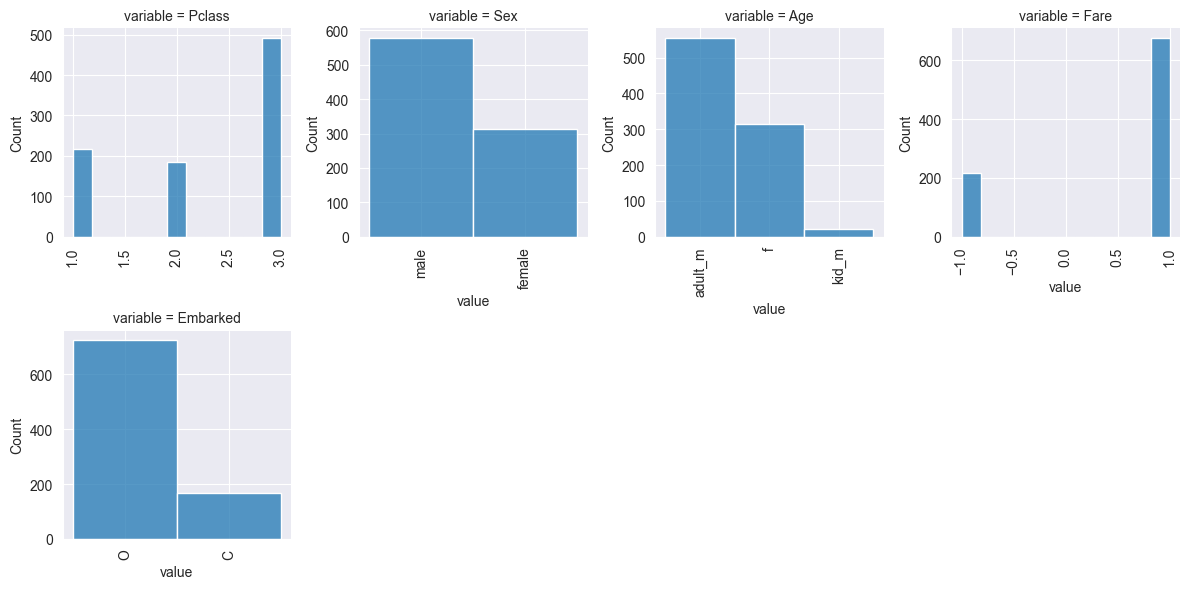

In [8]:
grid_plot(df)

In [9]:
df_data = pd.concat([df_oh, y], axis=1)
gbc, score, X_train, X_test, y_train, y_test = train_test_classifier(df_data[df_oh.columns], df_data[y.name], random_state=0, test_size=-1)
# gbc, score, X_train, X_test, y_train, y_test = train_test_classifier(df_data[df_oh.columns], df_data[y.name], random_state=0, test_size=-1, model=LogisticRegression())

In [10]:
if type(X_test) == pd.DataFrame:
    y_pred = gbc.predict(X_test)
    print(confusion_matrix(y_test, y_pred), score)

## Comparison with 100% dataset

In [11]:
df_test = pd.read_csv("../data/test.csv", index_col='PassengerId')
df100 = pd.read_csv("../data/submission.csv", index_col='PassengerId')
y100 = df100['Survived']

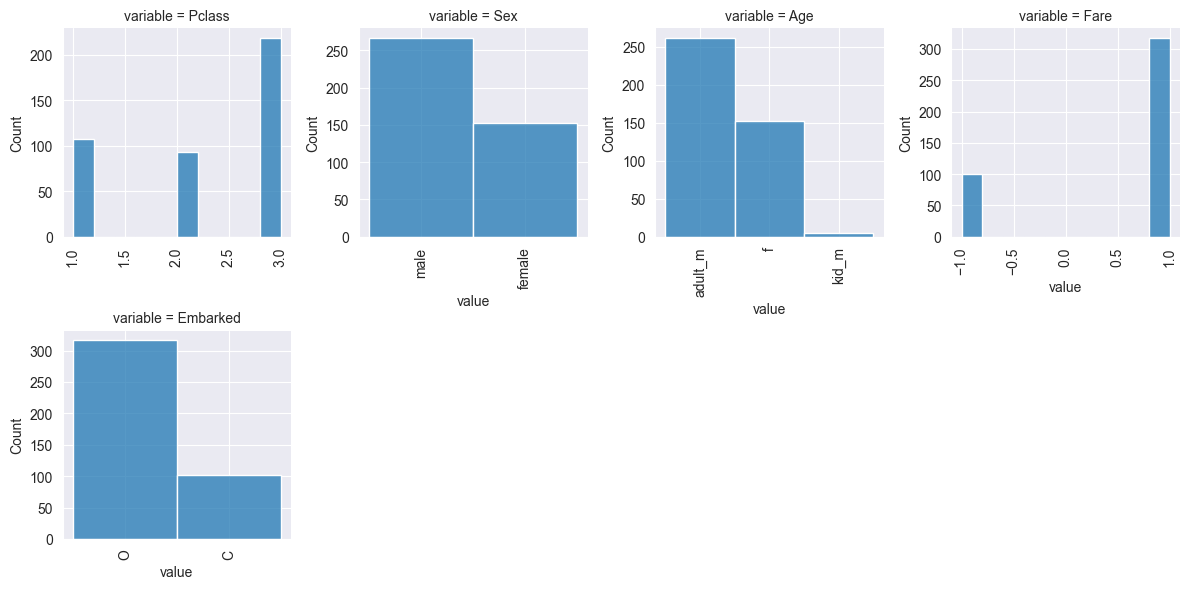

In [12]:
df_test_tr, df_test_oh = data_transform(df_test, df_data_columns, df_cat_cols, std_scaler, cats)
grid_plot(df_test_tr)

In [13]:
y_pred = gbc.predict(df_test_oh)
confusion_matrix(y100, y_pred), accuracy_score(y100, y_pred)

(array([[251,   9],
        [ 78,  80]], dtype=int64),
 0.7918660287081339)

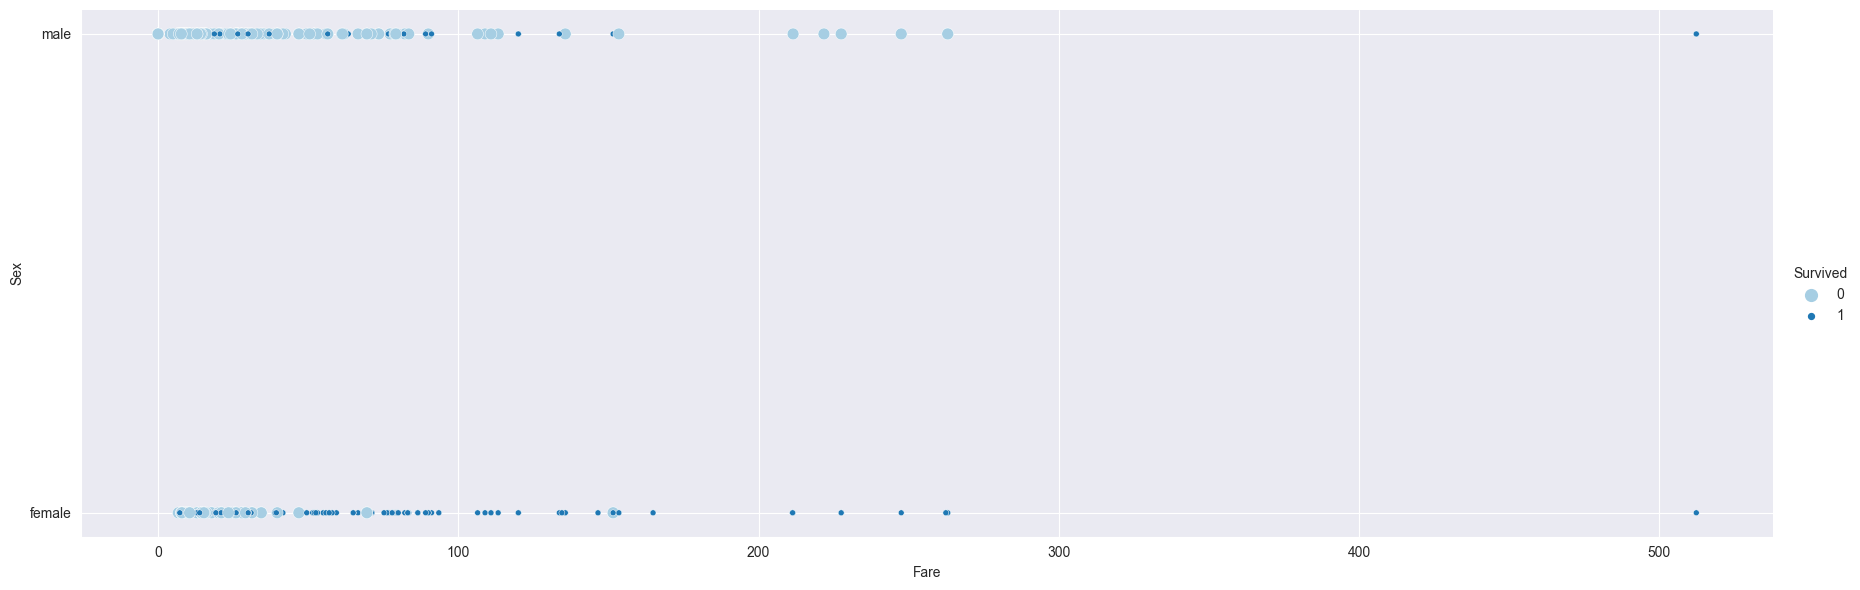

In [14]:
def cat_scatter(df,x,y,hue, height = 6, aspect = 1.5, palette='coolwarm'):
    sns.set_style("darkgrid")
    sns.relplot(data = df, x = x, y = y, hue = hue, height = height, aspect = aspect, size = hue, palette=palette)

cat_scatter(df_orig,'Fare', 'Sex', 'Survived',height=6,aspect=3, palette="Paired")

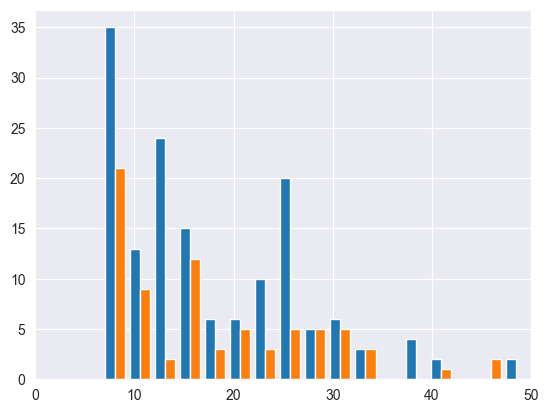

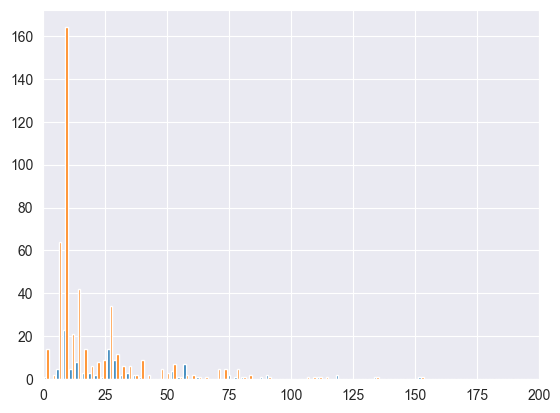

In [15]:
xf = [df_orig.loc[(df['Sex']=='female') & (y==1),'Fare'], df_orig.loc[(df['Sex']=='female') & (y==0),'Fare']]
xm = [df_orig.loc[(df['Sex']=='male') & (y==1),'Fare'], df_orig.loc[(df['Sex']=='male') & (y==0),'Fare']]
plt.xlim((0,50))
plt.hist(xf, bins = 200)
plt.show()
plt.xlim((0,200))
plt.hist(xm, bins = 200)
plt.show()